# Dependencies

In [1]:
import os
from os import path
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from collections import Counter
import glob
from natsort import natsorted
from moviepy.editor import *
import pandas as pd

# Bounding boxes

In [2]:
# box : (centerX, centerY, width, height)
def convertToAbsoluteValues(size, box):
    
    xIn = round(((2 * float(box[0]) - float(box[2])) * size[0] / 2))
    yIn = round(((2 * float(box[1]) - float(box[3])) * size[1] / 2))
    xEnd = xIn + round(float(box[2]) * size[0])
    yEnd = yIn + round(float(box[3]) * size[1])
    
    if xIn < 0:
        xIn = 0
    if yIn < 0:
        yIn = 0
    if xEnd >= size[0]:
        xEnd = size[0] - 1
    if yEnd >= size[1]:
        yEnd = size[1] - 1
    return (xIn, yIn, xEnd, yEnd)

# def convertToRelativeValues(size, box):
#     dw = 1. / (size[0])
#     dh = 1. / (size[1])
#     cx = (box[1] + box[0]) / 2.0
#     cy = (box[3] + box[2]) / 2.0
#     w = box[1] - box[0]
#     h = box[3] - box[2]
#     x = cx * dw
#     y = cy * dh
#     w = w * dw
#     h = h * dh
#     # x,y => (bounding_box_center)/width_of_the_image
#     # w => bounding_box_width / width_of_the_image
#     # h => bounding_box_height / height_of_the_image
#     return (x, y, w, h)

In [3]:
def boundingBoxes(labelPath, imagePath):
    
    detections, groundtruths, classes = [], [], []
    
    for boxtype in os.listdir(labelPath):

        boxtypeDir = os.path.join(labelPath,boxtype)
        
        for labelfile in os.listdir(boxtypeDir):
            filename = os.path.splitext(labelfile)[0]
            with open(os.path.join(boxtypeDir, labelfile)) as f: 
                labelinfos = f.readlines()   #텍스트 파일에 입력된 정보

            imgfilepath = os.path.join(imagePath, filename + ".jpg")
            img = cv.imread(imgfilepath)
            h, w, _ = img.shape

            for labelinfo in labelinfos:
                label, conf, rx1, ry1, rx2, ry2 = map(float, labelinfo.strip().split())
                x1, y1, x2, y2 = convertToAbsoluteValues((w, h), (rx1, ry1, rx2, ry2))
                boxinfo = [filename, label, conf, (x1, y1, x2, y2)]
                
                if label not in classes:
                    classes.append(label)
                
                if boxtype == "detection":
                    detections.append(boxinfo)
                else:
                    groundtruths.append(boxinfo)
                    
    classes = sorted(classes)
                
    return detections, groundtruths, classes

# Plot Bounding boxes

In [4]:
def boxPlot(boxlist, imagePath, savePath):
    labelfiles = sorted(list(set([filename for filename, _, _, _ in boxlist])))
    
    for labelfile in labelfiles:
    
        rectinfos = []
        imgfilePath = os.path.join(imagePath, labelfile + ".jpg")
        img = cv.imread(imgfilePath)

        for filename, _, conf, (x1, y1, x2, y2) in boxlist:
            if labelfile == filename:
                rectinfos.append((x1, y1, x2, y2, conf))
                
        for x1, y1, x2, y2, conf in rectinfos:
            
            if conf == 1.0:
                rectcolor = (0, 255, 0)
            else:
                rectcolor = (0, 0, 255)
                
            cv.rectangle(img, (x1, y1), (x2, y2), rectcolor, 4)
        # 경로가 없으면 만들어주기 
        if not path.isdir(savePath):
            os.makedirs(savePath)
        cv.imwrite(f"{savePath}/{labelfile}.jpg", img)

        img = mpimg.imread(f"{savePath}/{labelfile}.jpg")
#     boxPlot(detections_Kalman_n2 + groundtruths, image_path , savePath_Kalman_n2) 
        

# IoU(Intersection over Union)

In [5]:
def getArea(box):
    return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)


def getUnionAreas(boxA, boxB, interArea=None):
    area_A = getArea(boxA)
    area_B = getArea(boxB)
    
    if interArea is None:
        interArea = getIntersectionArea(boxA, boxB)
        
    return float(area_A + area_B - interArea)

def getIntersectionArea(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # intersection area
    return (xB - xA + 1) * (yB - yA + 1)

# boxA = (Ax1,Ay1,Ax2,Ay2)
# boxB = (Bx1,By1,Bx2,By2)
def boxesIntersect(boxA, boxB):
    if boxA[0] > boxB[2]:
        return False  # boxA is right of boxB
    if boxB[0] > boxA[2]:
        return False  # boxA is left of boxB
    if boxA[3] < boxB[1]:
        return False  # boxA is above boxB
    if boxA[1] > boxB[3]:
        return False  # boxA is below boxB
    return True

def iou(boxA, boxB):
    # if boxes dont intersect
    if boxesIntersect(boxA, boxB) is False:
        return 0
    interArea = getIntersectionArea(boxA, boxB)
    union = getUnionAreas(boxA, boxB, interArea=interArea)
    
    # intersection over union
    result = interArea / union
    assert result >= 0
    return result


def get_aver_iou(iou_array, Frames ):
    sum_iou = 0
    
    for i in iou_array:
        if i[1] != 0.0:
            sum_iou +=i[1]
        
    aver_iou = sum_iou / len(Frames)
    return aver_iou


# AP(Average Precision)

In [6]:
def calculateAveragePrecision(rec, prec):
    
    mrec = [0] + [e for e in rec] + [1]
    mpre = [0] + [e for e in prec] + [0]

    for i in range(len(mpre)-1, 0, -1):
        mpre[i-1] = max(mpre[i-1], mpre[i])

    ii = []

    for i in range(len(mrec)-1):
        if mrec[1:][i] != mrec[0:-1][i]:
            ii.append(i+1)

    ap = 0
    for i in ii:
        ap = ap + np.sum((mrec[i] - mrec[i-1]) * mpre[i])
    
    return [ap, mpre[0:len(mpre)-1], mrec[0:len(mpre)-1], ii]

In [7]:
def ElevenPointInterpolatedAP(rec, prec):

    mrec = [e for e in rec]
    mpre = [e for e in prec]

    recallValues = np.linspace(0, 1, 11)
    recallValues = list(recallValues[::-1])
    rhoInterp, recallValid = [], []

    for r in recallValues:
        argGreaterRecalls = np.argwhere(mrec[:] >= r)
        pmax = 0

        if argGreaterRecalls.size != 0:
            pmax = max(mpre[argGreaterRecalls.min():])

        recallValid.append(r)
        rhoInterp.append(pmax)

    ap = sum(rhoInterp) / 11

    return [ap, rhoInterp, recallValues, None]

In [8]:
def AP(detections, groundtruths, classes, IOUThreshold = 0.5, method = 'AP'):
    
    result = []
    
    for c in classes:

        dects = [d for d in detections if d[1] == c]
        gts = [g for g in groundtruths if g[1] == c]

        npos = len(gts)

        dects = sorted(dects, key = lambda conf : conf[2], reverse=True)

        TP = np.zeros(len(dects))
        FP = np.zeros(len(dects))

        det = Counter(cc[0] for cc in gts)

        # 각 이미지별 ground truth box의 수
        # {99 : 2, 380 : 4, ....}
        # {99 : [0, 0], 380 : [0, 0, 0, 0], ...}
        for key, val in det.items():
            det[key] = np.zeros(val)


        for d in range(len(dects)):


            gt = [gt for gt in gts if gt[0] == dects[d][0]]

            iouMax = 0

            for j in range(len(gt)):
                iou1 = iou(dects[d][3], gt[j][3])
                if iou1 > iouMax:
                    iouMax = iou1
                    jmax = j

            if iouMax >= IOUThreshold:
                if det[dects[d][0]][jmax] == 0:
                    TP[d] = 1
                    det[dects[d][0]][jmax] = 1
                else:
                    FP[d] = 1
            else:
                FP[d] = 1

        acc_FP = np.cumsum(FP)
        acc_TP = np.cumsum(TP)
        rec = acc_TP / npos
        prec = np.divide(acc_TP, (acc_FP + acc_TP))

        if method == "AP":
            [ap, mpre, mrec, ii] = calculateAveragePrecision(rec, prec)
        else:
            [ap, mpre, mrec, _] = ElevenPointInterpolatedAP(rec, prec)

        r = {
            'class' : c,
            'precision' : prec,
            'recall' : rec,
            'AP' : ap,
            'interpolated precision' : mpre,
            'interpolated recall' : mrec,
            'total positives' : npos,
            'total TP' : np.sum(TP),
            'total FP' : np.sum(FP)
        }

        result.append(r)

    return result



# mAP(mean Average Precision)

In [9]:
def mAP(result):
    ap = 0
    for r in result:
        ap += r['AP']
    mAP = ap / len(result)
    
    return mAP

# Class 

In [10]:
# Class 정의 
num2class = {"0.0" : "drone"}


ver_list = ['YOLO','Kalman','gicheol']
model_list = ['n','s','m','l','xl']
num_list = ['','2','3','4','5']


In [11]:
pwd


'/workspace/Dual_kalman'

# Save Bbox

In [12]:
image_path = "./MAP_dic/image"

#변수 생성
for model_name in model_list:
        for num in num_list:
            globals()['label_path_Kalman_{}{}'.format(model_name,num)] = "./yolo/prep_detect/Kalman/"+ model_name+'_labels'+ num     
            globals()['label_path_YOLO_{}{}'.format(model_name,num)] = "./yolo/prep_detect/YOLO/"+ model_name+'_labels'+ num   
            globals()['label_path_gicheol_{}{}'.format(model_name,num)] = "./yolo/prep_detect/gicheol/"+ model_name+'_labels'+ num   

  

In [14]:
print(label_path_gicheol_m2)

./yolo/prep_detect/gicheol/m_labels2


In [15]:
detections_YOLO_n, groundtruths, classes = boundingBoxes(label_path_YOLO_n, image_path)
detections_YOLO_n2, groundtruths, classes = boundingBoxes(label_path_YOLO_n2, image_path)
detections_YOLO_n3, groundtruths, classes = boundingBoxes(label_path_YOLO_n3, image_path)
detections_YOLO_n4, groundtruths, classes = boundingBoxes(label_path_YOLO_n4, image_path)
detections_YOLO_n5, groundtruths, classes = boundingBoxes(label_path_YOLO_n5, image_path)
detections_YOLO_s, groundtruths, classes = boundingBoxes(label_path_YOLO_s, image_path)
detections_YOLO_s2, groundtruths, classes = boundingBoxes(label_path_YOLO_s2, image_path)
detections_YOLO_s3, groundtruths, classes = boundingBoxes(label_path_YOLO_s3, image_path)
detections_YOLO_s4, groundtruths, classes = boundingBoxes(label_path_YOLO_s4, image_path)
detections_YOLO_s5, groundtruths, classes = boundingBoxes(label_path_YOLO_s5, image_path)
detections_YOLO_m, groundtruths, classes = boundingBoxes(label_path_YOLO_m, image_path)
detections_YOLO_m2, groundtruths, classes = boundingBoxes(label_path_YOLO_m2, image_path)
detections_YOLO_m3, groundtruths, classes = boundingBoxes(label_path_YOLO_m3, image_path)
detections_YOLO_m4, groundtruths, classes = boundingBoxes(label_path_YOLO_m4, image_path)
detections_YOLO_m5, groundtruths, classes = boundingBoxes(label_path_YOLO_m5, image_path)
detections_YOLO_l, groundtruths, classes = boundingBoxes(label_path_YOLO_l, image_path)
detections_YOLO_l2, groundtruths, classes = boundingBoxes(label_path_YOLO_l2, image_path)
detections_YOLO_l3, groundtruths, classes = boundingBoxes(label_path_YOLO_l3, image_path)
detections_YOLO_l4, groundtruths, classes = boundingBoxes(label_path_YOLO_l4, image_path)
detections_YOLO_l5, groundtruths, classes = boundingBoxes(label_path_YOLO_l5, image_path)
detections_YOLO_xl, groundtruths, classes = boundingBoxes(label_path_YOLO_xl, image_path)
detections_YOLO_xl2, groundtruths, classes = boundingBoxes(label_path_YOLO_xl2, image_path)
detections_YOLO_xl3, groundtruths, classes = boundingBoxes(label_path_YOLO_xl3, image_path)
detections_YOLO_xl4, groundtruths, classes = boundingBoxes(label_path_YOLO_xl4, image_path)
detections_YOLO_xl5, groundtruths, classes = boundingBoxes(label_path_YOLO_xl5, image_path)

In [16]:
detections_Kalman_n, groundtruths, classes = boundingBoxes(label_path_Kalman_n, image_path)
detections_Kalman_n2, groundtruths, classes = boundingBoxes(label_path_Kalman_n2, image_path)
detections_Kalman_n3, groundtruths, classes = boundingBoxes(label_path_Kalman_n3, image_path)
detections_Kalman_n4, groundtruths, classes = boundingBoxes(label_path_Kalman_n4, image_path)
detections_Kalman_n5, groundtruths, classes = boundingBoxes(label_path_Kalman_n5, image_path)
detections_Kalman_s, groundtruths, classes = boundingBoxes(label_path_Kalman_s, image_path)
detections_Kalman_s2, groundtruths, classes = boundingBoxes(label_path_Kalman_s2, image_path)
detections_Kalman_s3, groundtruths, classes = boundingBoxes(label_path_Kalman_s3, image_path)
detections_Kalman_s4, groundtruths, classes = boundingBoxes(label_path_Kalman_s4, image_path)
detections_Kalman_s5, groundtruths, classes = boundingBoxes(label_path_Kalman_s5, image_path)
detections_Kalman_m, groundtruths, classes = boundingBoxes(label_path_Kalman_m, image_path)
detections_Kalman_m2, groundtruths, classes = boundingBoxes(label_path_Kalman_m2, image_path)
detections_Kalman_m3, groundtruths, classes = boundingBoxes(label_path_Kalman_m3, image_path)
detections_Kalman_m4, groundtruths, classes = boundingBoxes(label_path_Kalman_m4, image_path)
detections_Kalman_m5, groundtruths, classes = boundingBoxes(label_path_Kalman_m5, image_path)
detections_Kalman_l, groundtruths, classes = boundingBoxes(label_path_Kalman_l, image_path)
detections_Kalman_l2, groundtruths, classes = boundingBoxes(label_path_Kalman_l2, image_path)
detections_Kalman_l3, groundtruths, classes = boundingBoxes(label_path_Kalman_l3, image_path)
detections_Kalman_l4, groundtruths, classes = boundingBoxes(label_path_Kalman_l4, image_path)
detections_Kalman_l5, groundtruths, classes = boundingBoxes(label_path_Kalman_l5, image_path)
detections_Kalman_xl, groundtruths, classes = boundingBoxes(label_path_Kalman_xl, image_path)
detections_Kalman_xl2, groundtruths, classes = boundingBoxes(label_path_Kalman_xl2, image_path)
detections_Kalman_xl3, groundtruths, classes = boundingBoxes(label_path_Kalman_xl3, image_path)
detections_Kalman_xl4, groundtruths, classes = boundingBoxes(label_path_Kalman_xl4, image_path)
detections_Kalman_xl5, groundtruths, classes = boundingBoxes(label_path_Kalman_xl5, image_path)


In [ ]:
detections_gicheol_n, groundtruths, classes = boundingBoxes(label_path_gicheol_n, image_path)
detections_gicheol_n2, groundtruths, classes = boundingBoxes(label_path_gicheol_n2, image_path)
detections_gicheol_n3, groundtruths, classes = boundingBoxes(label_path_gicheol_n3, image_path)
detections_gicheol_n4, groundtruths, classes = boundingBoxes(label_path_gicheol_n4, image_path)
detections_gicheol_n5, groundtruths, classes = boundingBoxes(label_path_gicheol_n5, image_path)
detections_gicheol_s, groundtruths, classes = boundingBoxes(label_path_gicheol_s, image_path)
detections_gicheol_s2, groundtruths, classes = boundingBoxes(label_path_gicheol_s2, image_path)
detections_gicheol_s3, groundtruths, classes = boundingBoxes(label_path_gicheol_s3, image_path)
detections_gicheol_s4, groundtruths, classes = boundingBoxes(label_path_gicheol_s4, image_path)
detections_gicheol_s5, groundtruths, classes = boundingBoxes(label_path_gicheol_s5, image_path)
detections_gicheol_m, groundtruths, classes = boundingBoxes(label_path_gicheol_m, image_path)
detections_gicheol_m2, groundtruths, classes = boundingBoxes(label_path_gicheol_m2, image_path)
detections_gicheol_m3, groundtruths, classes = boundingBoxes(label_path_gicheol_m3, image_path)
detections_gicheol_m4, groundtruths, classes = boundingBoxes(label_path_gicheol_m4, image_path)
detections_gicheol_m5, groundtruths, classes = boundingBoxes(label_path_gicheol_m5, image_path)
detections_gicheol_l, groundtruths, classes = boundingBoxes(label_path_gicheol_l, image_path)
detections_gicheol_l2, groundtruths, classes = boundingBoxes(label_path_gicheol_l2, image_path)
detections_gicheol_l3, groundtruths, classes = boundingBoxes(label_path_gicheol_l3, image_path)
detections_gicheol_l4, groundtruths, classes = boundingBoxes(label_path_gicheol_l4, image_path)
detections_gicheol_l5, groundtruths, classes = boundingBoxes(label_path_gicheol_l5, image_path)
detections_gicheol_xl, groundtruths, classes = boundingBoxes(label_path_gicheol_xl, image_path)
detections_gicheol_xl2, groundtruths, classes = boundingBoxes(label_path_gicheol_xl2, image_path)
detections_gicheol_xl3, groundtruths, classes = boundingBoxes(label_path_gicheol_xl3, image_path)
detections_gicheol_xl4, groundtruths, classes = boundingBoxes(label_path_gicheol_xl4, image_path)
detections_gicheol_xl5, groundtruths, classes = boundingBoxes(label_path_gicheol_xl5, image_path)

In [ ]:
print("Detection Success Frames(YOLO_n) : %d"%len(detections_YOLO_n))
print("Detection Success Frames(YOLO_n2) : %d"%len(detections_YOLO_n2))
print("Detection Success Frames(YOLO_n3) : %d"%len(detections_YOLO_n3))
print("Detection Success Frames(YOLO_n4) : %d"%len(detections_YOLO_n4))
print("Detection Success Frames(YOLO_n5) : %d"%len(detections_YOLO_n5))

print("============================================")

print("Detection Success Frames(YOLO_s) : %d"%len(detections_YOLO_s))
print("Detection Success Frames(YOLO_s2) : %d"%len(detections_YOLO_s2))
print("Detection Success Frames(YOLO_s3) : %d"%len(detections_YOLO_s3))
print("Detection Success Frames(YOLO_s4) : %d"%len(detections_YOLO_s4))
print("Detection Success Frames(YOLO_s5) : %d"%len(detections_YOLO_s5))


print("============================================")

print("Detection Success Frames(YOLO_m) : %d"%len(detections_YOLO_m))
print("Detection Success Frames(YOLO_m2) : %d"%len(detections_YOLO_m2))
print("Detection Success Frames(YOLO_m3) : %d"%len(detections_YOLO_m3))
print("Detection Success Frames(YOLO_m4) : %d"%len(detections_YOLO_m4))
print("Detection Success Frames(YOLO_m5) : %d"%len(detections_YOLO_m5))

print("============================================")

print("Detection Success Frames(YOLO_l) : %d"%len(detections_YOLO_l))
print("Detection Success Frames(YOLO_l2) : %d"%len(detections_YOLO_l2))
print("Detection Success Frames(YOLO_l3) : %d"%len(detections_YOLO_l3))
print("Detection Success Frames(YOLO_l4) : %d"%len(detections_YOLO_l4))
print("Detection Success Frames(YOLO_l5) : %d"%len(detections_YOLO_l5))

print("============================================")

print("Detection Success Frames(YOLO_xl) : %d"%len(detections_YOLO_xl))
print("Detection Success Frames(YOLO_xl2) : %d"%len(detections_YOLO_xl2))
print("Detection Success Frames(YOLO_xl3) : %d"%len(detections_YOLO_xl3))
print("Detection Success Frames(YOLO_xl4) : %d"%len(detections_YOLO_xl4))
print("Detection Success Frames(YOLO_xl5) : %d"%len(detections_YOLO_xl5))

print("============================================")

print("Detection Success Frames(gicheol_n) : %d"%len(detections_gicheol_n))
print("Detection Success Frames(gicheol_n2) : %d"%len(detections_gicheol_n2))
print("Detection Success Frames(gicheol_n3) : %d"%len(detections_gicheol_n3))
print("Detection Success Frames(gicheol_n4) : %d"%len(detections_gicheol_n4))
print("Detection Success Frames(gicheol_n5) : %d"%len(detections_gicheol_n5))
print("============================================")
print("Detection Success Frames(gicheol_s) : %d"%len(detections_gicheol_s))
print("Detection Success Frames(gicheol_s2) : %d"%len(detections_gicheol_s2))
print("Detection Success Frames(gicheol_s3) : %d"%len(detections_gicheol_s3))
print("Detection Success Frames(gicheol_s4 : %d"%len(detections_gicheol_s4))
print("Detection Success Frames(gicheol_s5 : %d"%len(detections_gicheol_s5))
print("============================================")
print("Detection Success Frames(gicheol_m) : %d"%len(detections_gicheol_m))
print("Detection Success Frames(gicheol_m2) : %d"%len(detections_gicheol_m2))
print("Detection Success Frames(gicheol_m3) : %d"%len(detections_gicheol_m3))
print("Detection Success Frames(gicheol_m4) : %d"%len(detections_gicheol_m4))
print("Detection Success Frames(gicheol_m5) : %d"%len(detections_gicheol_m5))
print("============================================")

print("Detection Success Frames(gicheol_l) : %d"%len(detections_gicheol_l))
print("Detection Success Frames(gicheol_l2) : %d"%len(detections_gicheol_l2))
print("Detection Success Frames(gicheol_l3) : %d"%len(detections_gicheol_l3))
print("Detection Success Frames(gicheol_l4) : %d"%len(detections_gicheol_l4))
print("Detection Success Frames(gicheol_l5) : %d"%len(detections_gicheol_l5))
print("============================================")
print("Detection Success Frames(gicheol_xl) : %d"%len(detections_gicheol_xl))
print("Detection Success Frames(gicheol_xl2) : %d"%len(detections_gicheol_xl2))
print("Detection Success Frames(gicheol_xl3) : %d"%len(detections_gicheol_xl3))
print("Detection Success Frames(gicheol_xl4) : %d"%len(detections_gicheol_xl4))
print("Detection Success Frames(gicheol_xl5) : %d"%len(detections_gicheol_xl5))
print("============================================")




print("============================================")

print("Detection Success Frames(Kalman_n) : %d"%len(detections_Kalman_n))
print("Detection Success Frames(Kalman_n2) : %d"%len(detections_Kalman_n2))
print("Detection Success Frames(Kalman_n3) : %d"%len(detections_Kalman_n3))
print("Detection Success Frames(Kalman_n4) : %d"%len(detections_Kalman_n4))
print("Detection Success Frames(Kalman_n5) : %d"%len(detections_Kalman_n5))
print("============================================")
print("Detection Success Frames(Kalman_s) : %d"%len(detections_Kalman_s))
print("Detection Success Frames(Kalman_s2) : %d"%len(detections_Kalman_s2))
print("Detection Success Frames(Kalman_s3) : %d"%len(detections_Kalman_s3))
print("Detection Success Frames(Kalman_s4 : %d"%len(detections_Kalman_s4))
print("Detection Success Frames(Kalman_s5 : %d"%len(detections_Kalman_s5))
print("============================================")
print("Detection Success Frames(Kalman_m) : %d"%len(detections_Kalman_m))
print("Detection Success Frames(Kalman_m2) : %d"%len(detections_Kalman_m2))
print("Detection Success Frames(Kalman_m3) : %d"%len(detections_Kalman_m3))
print("Detection Success Frames(Kalman_m4) : %d"%len(detections_Kalman_m4))
print("Detection Success Frames(Kalman_m5) : %d"%len(detections_Kalman_m5))
print("============================================")

print("Detection Success Frames(Kalman_l) : %d"%len(detections_Kalman_l))
print("Detection Success Frames(Kalman_l2) : %d"%len(detections_Kalman_l2))
print("Detection Success Frames(Kalman_l3) : %d"%len(detections_Kalman_l3))
print("Detection Success Frames(Kalman_l4) : %d"%len(detections_Kalman_l4))
print("Detection Success Frames(Kalman_l5) : %d"%len(detections_Kalman_l5))
print("============================================")
print("Detection Success Frames(Kalman_xl) : %d"%len(detections_Kalman_xl))
print("Detection Success Frames(Kalman_xl2) : %d"%len(detections_Kalman_xl2))
print("Detection Success Frames(Kalman_xl3) : %d"%len(detections_Kalman_xl3))
print("Detection Success Frames(Kalman_xl4) : %d"%len(detections_Kalman_xl4))
print("Detection Success Frames(Kalman_xl5) : %d"%len(detections_Kalman_xl5))
print("============================================")


print("Groundtruth Frames : %d"%len(groundtruths))
print("Number of Classes : %d"%len(classes))

# Save Bbox Image

In [ ]:
savePath="./yolo/save_box_result"

for model_name in model_list:
        for num in num_list:
            globals()['savePath_Kalman_{}{}'.format(model_name, num)] = savePath+"/Kalman/"+ model_name + num +'_images'
            globals()['savePath_YOLO_{}{}'.format(model_name, num)] = savePath+"/YOLO/"+ model_name + num +'_images' 
            globals()['savePath_gicheol_{}{}'.format(model_name, num)] = savePath+"/gicheol/"+ model_name + num +'_images' 
            
print(savePath_Kalman_n2)
print(savePath_YOLO_n4)
print(savePath_gicheol_l3)


In [19]:
boxPlot(detections_Kalman_n + groundtruths, image_path , savePath_Kalman_n
boxPlot(detections_Kalman_n2 + groundtruths, image_path , savePath_Kalman_n2)
boxPlot(detections_Kalman_n3 + groundtruths, image_path , savePath_Kalman_n3)
boxPlot(detections_Kalman_n4 + groundtruths, image_path , savePath_Kalman_n4)
boxPlot(detections_Kalman_n5 + groundtruths, image_path , savePath_Kalman_n5)

boxPlot(detections_Kalman_s + groundtruths, image_path , savePath_Kalman_s)
boxPlot(detections_Kalman_s2 + groundtruths, image_path , savePath_Kalman_s2)
boxPlot(detections_Kalman_s3 + groundtruths, image_path , savePath_Kalman_s3)
boxPlot(detections_Kalman_s4 + groundtruths, image_path , savePath_Kalman_s4)
boxPlot(detections_Kalman_s5 + groundtruths, image_path , savePath_Kalman_s5)

boxPlot(detections_Kalman_m + groundtruths, image_path , savePath_Kalman_m)
boxPlot(detections_Kalman_m2 + groundtruths, image_path , savePath_Kalman_m2)
boxPlot(detections_Kalman_m3 + groundtruths, image_path , savePath_Kalman_m3)
boxPlot(detections_Kalman_m4 + groundtruths, image_path , savePath_Kalman_m4)
boxPlot(detections_Kalman_m5 + groundtruths, image_path , savePath_Kalman_m5)


boxPlot(detections_Kalman_l + groundtruths, image_path , savePath_Kalman_l)
boxPlot(detections_Kalman_l2 + groundtruths, image_path , savePath_Kalman_l2)
boxPlot(detections_Kalman_l3 + groundtruths, image_path , savePath_Kalman_l3)
boxPlot(detections_Kalman_l4 + groundtruths, image_path , savePath_Kalman_l4)
boxPlot(detections_Kalman_l5 + groundtruths, image_path , savePath_Kalman_l5)

boxPlot(detections_Kalman_xl + groundtruths, image_path , savePath_Kalman_xl)
boxPlot(detections_Kalman_xl2 + groundtruths, image_path , savePath_Kalman_xl2)
boxPlot(detections_Kalman_xl3 + groundtruths, image_path , savePath_Kalman_xl3)
boxPlot(detections_Kalman_xl4 + groundtruths, image_path , savePath_Kalman_xl4)
boxPlot(detections_Kalman_xl5 + groundtruths, image_path , savePath_Kalman_xl5)

In [20]:
boxPlot(detections_YOLO_n + groundtruths, image_path , savePath_YOLO_n)
boxPlot(detections_YOLO_n2 + groundtruths, image_path , savePath_YOLO_n2)
boxPlot(detections_YOLO_n3 + groundtruths, image_path , savePath_YOLO_n3)
boxPlot(detections_YOLO_n4 + groundtruths, image_path , savePath_YOLO_n4)
boxPlot(detections_YOLO_n5 + groundtruths, image_path , savePath_YOLO_n5)

boxPlot(detections_YOLO_s + groundtruths, image_path , savePath_YOLO_s)
boxPlot(detections_YOLO_s2 + groundtruths, image_path , savePath_YOLO_s2)
boxPlot(detections_YOLO_s3 + groundtruths, image_path , savePath_YOLO_s3)
boxPlot(detections_YOLO_s4 + groundtruths, image_path , savePath_YOLO_s4)
boxPlot(detections_YOLO_s5 + groundtruths, image_path , savePath_YOLO_s5)
        
        
boxPlot(detections_YOLO_m + groundtruths, image_path , savePath_YOLO_m)
boxPlot(detections_YOLO_m2 + groundtruths, image_path , savePath_YOLO_m2)
boxPlot(detections_YOLO_m3 + groundtruths, image_path , savePath_YOLO_m3)
boxPlot(detections_YOLO_m4 + groundtruths, image_path , savePath_YOLO_m4)
boxPlot(detections_YOLO_m5 + groundtruths, image_path , savePath_YOLO_m5)

boxPlot(detections_YOLO_l + groundtruths, image_path , savePath_YOLO_l)
boxPlot(detections_YOLO_l2 + groundtruths, image_path , savePath_YOLO_l2)
boxPlot(detections_YOLO_l3 + groundtruths, image_path , savePath_YOLO_l3)
boxPlot(detections_YOLO_l4 + groundtruths, image_path , savePath_YOLO_l4)
boxPlot(detections_YOLO_l5 + groundtruths, image_path , savePath_YOLO_l5)

boxPlot(detections_YOLO_xl + groundtruths, image_path , savePath_YOLO_xl)
boxPlot(detections_YOLO_xl2 + groundtruths, image_path , savePath_YOLO_xl2)
boxPlot(detections_YOLO_xl3 + groundtruths, image_path , savePath_YOLO_xl3)
boxPlot(detections_YOLO_xl4 + groundtruths, image_path , savePath_YOLO_xl4)
boxPlot(detections_YOLO_xl5 + groundtruths, image_path , savePath_YOLO_xl5)


In [21]:
boxPlot(detections_gicheol_n + groundtruths, image_path , savePath_gicheol_n)
boxPlot(detections_gicheol_n2 + groundtruths, image_path , savePath_gicheol_n2)
boxPlot(detections_gicheol_n3 + groundtruths, image_path , savePath_gicheol_n3)
boxPlot(detections_gicheol_n4 + groundtruths, image_path , savePath_gicheol_n4)
boxPlot(detections_gicheol_n5 + groundtruths, image_path , savePath_gicheol_n5)

boxPlot(detections_gicheol_s + groundtruths, image_path , savePath_gicheol_s)
boxPlot(detections_gicheol_s2 + groundtruths, image_path , savePath_gicheol_s2)
boxPlot(detections_gicheol_s3 + groundtruths, image_path , savePath_gicheol_s3)
boxPlot(detections_gicheol_s4 + groundtruths, image_path , savePath_gicheol_s4)
boxPlot(detections_gicheol_s5 + groundtruths, image_path , savePath_gicheol_s5)
        
        
boxPlot(detections_gicheol_m + groundtruths, image_path , savePath_gicheol_m)
boxPlot(detections_gicheol_m2 + groundtruths, image_path , savePath_gicheol_m2)
boxPlot(detections_gicheol_m3 + groundtruths, image_path , savePath_gicheol_m3)
boxPlot(detections_gicheol_m4 + groundtruths, image_path , savePath_gicheol_m4)
boxPlot(detections_gicheol_m5 + groundtruths, image_path , savePath_gicheol_m5)

boxPlot(detections_gicheol_l + groundtruths, image_path , savePath_gicheol_l)
boxPlot(detections_gicheol_l2 + groundtruths, image_path , savePath_gicheol_l2)
boxPlot(detections_gicheol_l3 + groundtruths, image_path , savePath_gicheol_l3)
boxPlot(detections_gicheol_l4 + groundtruths, image_path , savePath_gicheol_l4)
boxPlot(detections_gicheol_l5 + groundtruths, image_path , savePath_gicheol_l5)

boxPlot(detections_gicheol_xl + groundtruths, image_path , savePath_gicheol_xl)
boxPlot(detections_gicheol_xl2 + groundtruths, image_path , savePath_gicheol_xl2)
boxPlot(detections_gicheol_xl3 + groundtruths, image_path , savePath_gicheol_xl3)
boxPlot(detections_gicheol_xl4 + groundtruths, image_path , savePath_gicheol_xl4)
boxPlot(detections_gicheol_xl5 + groundtruths, image_path , savePath_gicheol_xl5)


# Save AVI File

In [20]:
#ver_list = ['YOLO','Kalman']
#model_list = ['n','s','m','l','xl']
#savePath_YOLO_n
#savePath="./yolov5/save_box_result"

savePath="./yolo/save_box_result"
for ver_name in ver_list:
    for model_name in model_list:
        for num in num_list:
            img_array = []
            for filename in natsorted(glob.glob((savePath+'/'+ver_name+'/'+model_name+num+'_images')+'/*.jpg')):

                img = cv.imread(filename)

                h, w, layers = img.shape
                size = ( w , h )
                img_array.append(img)

            out = cv.VideoWriter(('save_video/'+ver_name+'_'+model_name+num+'_Result.avi'), cv.VideoWriter_fourcc(*'DIVX'), 30,  size)
            for i in range(len(img_array)):
                out.write(img_array[i])
            out.release()

# Save GIF File

In [21]:
for ver_name in ver_list:
    for model_name in model_list:
        print('save_video/'+ver_name+'_'+model_name+'_Result.avi')
        VideoFileClip('save_video/'+ver_name+'_'+model_name+'_Result.avi').speedx(4).write_gif('save_video/'+ver_name+'_'+model_name+'_Result.gif')
        

save_video/YOLO_n_Result.avi
MoviePy - Building file save_video/YOLO_n_Result.gif with imageio.


save_video/YOLO_s_Result.avi
MoviePy - Building file save_video/YOLO_s_Result.gif with imageio.


save_video/YOLO_m_Result.avi
MoviePy - Building file save_video/YOLO_m_Result.gif with imageio.


save_video/YOLO_l_Result.avi
MoviePy - Building file save_video/YOLO_l_Result.gif with imageio.


save_video/YOLO_xl_Result.avi
MoviePy - Building file save_video/YOLO_xl_Result.gif with imageio.


save_video/Kalman_n_Result.avi
MoviePy - Building file save_video/Kalman_n_Result.gif with imageio.


save_video/Kalman_s_Result.avi
MoviePy - Building file save_video/Kalman_s_Result.gif with imageio.


save_video/Kalman_m_Result.avi
MoviePy - Building file save_video/Kalman_m_Result.gif with imageio.


save_video/Kalman_l_Result.avi
MoviePy - Building file save_video/Kalman_l_Result.gif with imageio.


save_video/Kalman_xl_Result.avi
MoviePy - Building file save_video/Kalman_xl_Result.gif with imageio.


# Save IOU 

In [ ]:
#리스트 생성
for model_name in model_list:
    for num in num_list:
        globals()['iou_list_Kalman_{}{}'.format(model_name, num)] = []
        globals()['iou_list_YOLO_{}{}'.format(model_name, num)] = []
        globals()['iou_list_gicheol_{}{}'.format(model_name, num)] = []
print(iou_list_Kalman_xl5)

In [ ]:
for groundtruth in groundtruths: 
    #YOLO 
    for detection in detections_YOLO_n:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_n.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_n2:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_n2.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_n3:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_n3.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_n4:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_n4.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_n5:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_n5.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
            
    for detection in detections_YOLO_s:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_s.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_s2:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_s2.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_s3:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_s3.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_s4:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_s4.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_s5:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_s5.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    
    
    
    for detection in detections_YOLO_m:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_m.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_m2:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_m2.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_m3:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_m3.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_m4:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_m4.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_m5:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_m5.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
            
    for detection in detections_YOLO_l:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_l.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_l2:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_l2.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_l3:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_l3.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_l4:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_l4.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_l5:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_l5.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    
    
    for detection in detections_YOLO_xl:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_xl.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_xl2:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_xl2.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_xl3:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_xl3.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_xl4:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_xl4.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_YOLO_xl5:
        if detection[0] == groundtruth[0]:
            iou_list_YOLO_xl5.append([detection[0] , iou(detection[-1] , groundtruth[-1])])

    
    for detection in detections_Kalman_n:
        if detection[0] == groundtruth[0]:
            iou_list_Kalman_n.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_n2:
        if detection[0] == groundtruth[0]:
            iou_list_Kalman_n2.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_n3:
        if detection[0] == groundtruth[0]:
            iou_list_Kalman_n3.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_n4:
        if detection[0] == groundtruth[0]:
            iou_list_Kalman_n4.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_n5:
        if detection[0] == groundtruth[0]:
            iou_list_Kalman_n5.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
            
            
            
    for detection in detections_Kalman_s:
        if detection[0] == groundtruth[0]:
            iou_list_Kalman_s.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_s2:
        if detection[0] == groundtruth[0]:
            iou_list_Kalman_s2.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_s3:
        if detection[0] == groundtruth[0]:
            iou_list_Kalman_s3.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_s4:
        if detection[0] == groundtruth[0]:
            iou_list_Kalman_s4.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_s5:
        if detection[0] == groundtruth[0]:
            iou_list_Kalman_s5.append([detection[0] , iou(detection[-1] , groundtruth[-1])])

            
    for detection in detections_Kalman_m:
            if detection[0] == groundtruth[0]:
                iou_list_Kalman_m.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_m2:
            if detection[0] == groundtruth[0]:
                iou_list_Kalman_m2.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_m3:
            if detection[0] == groundtruth[0]:
                iou_list_Kalman_m3.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_m4:
            if detection[0] == groundtruth[0]:
                iou_list_Kalman_m4.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_m5:
            if detection[0] == groundtruth[0]:
                iou_list_Kalman_m5.append([detection[0] , iou(detection[-1] , groundtruth[-1])])

    for detection in detections_Kalman_l:
            if detection[0] == groundtruth[0]:
                iou_list_Kalman_l.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_l2:
            if detection[0] == groundtruth[0]:
                iou_list_Kalman_l2.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_l3:
            if detection[0] == groundtruth[0]:
                iou_list_Kalman_l3.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_l4:
            if detection[0] == groundtruth[0]:
                iou_list_Kalman_l4.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_l5:
            if detection[0] == groundtruth[0]:
                iou_list_Kalman_l5.append([detection[0] , iou(detection[-1] , groundtruth[-1])])

    for detection in detections_Kalman_xl:
            if detection[0] == groundtruth[0]:
                iou_list_Kalman_xl.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_xl2:
            if detection[0] == groundtruth[0]:
                iou_list_Kalman_xl2.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_xl3:
            if detection[0] == groundtruth[0]:
                iou_list_Kalman_xl3.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_xl4:
            if detection[0] == groundtruth[0]:
                iou_list_Kalman_xl4.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_Kalman_xl5:
            if detection[0] == groundtruth[0]:
                iou_list_Kalman_xl5.append([detection[0] , iou(detection[-1] , groundtruth[-1])])

                
                
    for detection in detections_gicheol_n:
        if detection[0] == groundtruth[0]:
            iou_list_gicheol_n.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_n2:
        if detection[0] == groundtruth[0]:
            iou_list_gicheol_n2.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_n3:
        if detection[0] == groundtruth[0]:
            iou_list_gicheol_n3.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_n4:
        if detection[0] == groundtruth[0]:
            iou_list_gicheol_n4.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_n5:
        if detection[0] == groundtruth[0]:
            iou_list_gicheol_n5.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
            
            
            
    for detection in detections_gicheol_s:
        if detection[0] == groundtruth[0]:
            iou_list_gicheol_s.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_s2:
        if detection[0] == groundtruth[0]:
            iou_list_gicheol_s2.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_s3:
        if detection[0] == groundtruth[0]:
            iou_list_gicheol_s3.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_s4:
        if detection[0] == groundtruth[0]:
            iou_list_gicheol_s4.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_s5:
        if detection[0] == groundtruth[0]:
            iou_list_gicheol_s5.append([detection[0] , iou(detection[-1] , groundtruth[-1])])

            
    for detection in detections_gicheol_m:
            if detection[0] == groundtruth[0]:
                iou_list_gicheol_m.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_m2:
            if detection[0] == groundtruth[0]:
                iou_list_gicheol_m2.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_m3:
            if detection[0] == groundtruth[0]:
                iou_list_gicheol_m3.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_m4:
            if detection[0] == groundtruth[0]:
                iou_list_gicheol_m4.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_m5:
            if detection[0] == groundtruth[0]:
                iou_list_gicheol_m5.append([detection[0] , iou(detection[-1] , groundtruth[-1])])

    for detection in detections_gicheol_l:
            if detection[0] == groundtruth[0]:
                iou_list_gicheol_l.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_l2:
            if detection[0] == groundtruth[0]:
                iou_list_gicheol_l2.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_l3:
            if detection[0] == groundtruth[0]:
                iou_list_gicheol_l3.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_l4:
            if detection[0] == groundtruth[0]:
                iou_list_gicheol_l4.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_l5:
            if detection[0] == groundtruth[0]:
                iou_list_gicheol_l5.append([detection[0] , iou(detection[-1] , groundtruth[-1])])

    for detection in detections_gicheol_xl:
            if detection[0] == groundtruth[0]:
                iou_list_gicheol_xl.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_xl2:
            if detection[0] == groundtruth[0]:
                iou_list_gicheol_xl2.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_xl3:
            if detection[0] == groundtruth[0]:
                iou_list_gicheol_xl3.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_xl4:
            if detection[0] == groundtruth[0]:
                iou_list_gicheol_xl4.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
    for detection in detections_gicheol_xl5:
            if detection[0] == groundtruth[0]:
                iou_list_gicheol_xl5.append([detection[0] , iou(detection[-1] , groundtruth[-1])])
#프레임수로 정렬
#YOLO
iou_list_YOLO_n = natsorted(iou_list_YOLO_n)
iou_list_YOLO_n2 = natsorted(iou_list_YOLO_n2)
iou_list_YOLO_n3 = natsorted(iou_list_YOLO_n3)
iou_list_YOLO_n4 = natsorted(iou_list_YOLO_n4)
iou_list_YOLO_n5 = natsorted(iou_list_YOLO_n5)

iou_list_YOLO_s = natsorted(iou_list_YOLO_s)
iou_list_YOLO_s2 = natsorted(iou_list_YOLO_s2)
iou_list_YOLO_s3 = natsorted(iou_list_YOLO_s3)
iou_list_YOLO_s4 = natsorted(iou_list_YOLO_s4)
iou_list_YOLO_s5 = natsorted(iou_list_YOLO_s5)

iou_list_YOLO_m = natsorted(iou_list_YOLO_m)
iou_list_YOLO_m2 = natsorted(iou_list_YOLO_m2)
iou_list_YOLO_m3 = natsorted(iou_list_YOLO_m3)
iou_list_YOLO_m4 = natsorted(iou_list_YOLO_m4)
iou_list_YOLO_m5 = natsorted(iou_list_YOLO_m5)

iou_list_YOLO_l = natsorted(iou_list_YOLO_l)
iou_list_YOLO_l2 = natsorted(iou_list_YOLO_l2)
iou_list_YOLO_l3 = natsorted(iou_list_YOLO_l3)
iou_list_YOLO_l4 = natsorted(iou_list_YOLO_l4)
iou_list_YOLO_l5 = natsorted(iou_list_YOLO_l5)

iou_list_YOLO_xl = natsorted(iou_list_YOLO_xl)
iou_list_YOLO_xl2 = natsorted(iou_list_YOLO_xl2)
iou_list_YOLO_xl3 = natsorted(iou_list_YOLO_xl3)
iou_list_YOLO_xl4 = natsorted(iou_list_YOLO_xl4)
iou_list_YOLO_xl5 = natsorted(iou_list_YOLO_xl5)


#Kalman
iou_list_Kalman_n = natsorted(iou_list_Kalman_n)
iou_list_Kalman_n2 = natsorted(iou_list_Kalman_n2)
iou_list_Kalman_n3 = natsorted(iou_list_Kalman_n3)
iou_list_Kalman_n4 = natsorted(iou_list_Kalman_n4)
iou_list_Kalman_n5 = natsorted(iou_list_Kalman_n5)

iou_list_Kalman_s = natsorted(iou_list_Kalman_s)    
iou_list_Kalman_s2 = natsorted(iou_list_Kalman_s2)    
iou_list_Kalman_s3 = natsorted(iou_list_Kalman_s3)    
iou_list_Kalman_s4 = natsorted(iou_list_Kalman_s4)    
iou_list_Kalman_s5 = natsorted(iou_list_Kalman_s5)    

iou_list_Kalman_m = natsorted(iou_list_Kalman_m)    
iou_list_Kalman_m2 = natsorted(iou_list_Kalman_m2)    
iou_list_Kalman_m3 = natsorted(iou_list_Kalman_m3)    
iou_list_Kalman_m4 = natsorted(iou_list_Kalman_m4)    
iou_list_Kalman_m5 = natsorted(iou_list_Kalman_m5)    

iou_list_Kalman_l = natsorted(iou_list_Kalman_l)    
iou_list_Kalman_l2 = natsorted(iou_list_Kalman_l2)    
iou_list_Kalman_l3 = natsorted(iou_list_Kalman_l3)    
iou_list_Kalman_l4 = natsorted(iou_list_Kalman_l4)    
iou_list_Kalman_l5 = natsorted(iou_list_Kalman_l5)    

iou_list_Kalman_xl = natsorted(iou_list_Kalman_xl)
iou_list_Kalman_xl2 = natsorted(iou_list_Kalman_xl2)
iou_list_Kalman_xl3 = natsorted(iou_list_Kalman_xl3)
iou_list_Kalman_xl4 = natsorted(iou_list_Kalman_xl4)
iou_list_Kalman_xl5 = natsorted(iou_list_Kalman_xl5)


#gicheol
iou_list_gicheol_n = natsorted(iou_list_gicheol_n)
iou_list_gicheol_n2 = natsorted(iou_list_gicheol_n2)
iou_list_gicheol_n3 = natsorted(iou_list_gicheol_n3)
iou_list_gicheol_n4 = natsorted(iou_list_gicheol_n4)
iou_list_gicheol_n5 = natsorted(iou_list_gicheol_n5)

iou_list_gicheol_s = natsorted(iou_list_gicheol_s)    
iou_list_gicheol_s2 = natsorted(iou_list_gicheol_s2)    
iou_list_gicheol_s3 = natsorted(iou_list_gicheol_s3)    
iou_list_gicheol_s4 = natsorted(iou_list_gicheol_s4)    
iou_list_gicheol_s5 = natsorted(iou_list_gicheol_s5)    

iou_list_gicheol_m = natsorted(iou_list_gicheol_m)    
iou_list_gicheol_m2 = natsorted(iou_list_gicheol_m2)    
iou_list_gicheol_m3 = natsorted(iou_list_gicheol_m3)    
iou_list_gicheol_m4 = natsorted(iou_list_gicheol_m4)    
iou_list_gicheol_m5= natsorted(iou_list_gicheol_m5)    

iou_list_gicheol_l = natsorted(iou_list_gicheol_l)    
iou_list_gicheol_l2 = natsorted(iou_list_gicheol_l2)    
iou_list_gicheol_l3 = natsorted(iou_list_gicheol_l3)    
iou_list_gicheol_l4 = natsorted(iou_list_gicheol_l4)    
iou_list_gicheol_l5 = natsorted(iou_list_gicheol_l5)    

iou_list_gicheol_xl = natsorted(iou_list_gicheol_xl)
iou_list_gicheol_xl2 = natsorted(iou_list_gicheol_xl2)
iou_list_gicheol_xl3 = natsorted(iou_list_gicheol_xl3)
iou_list_gicheol_xl4 = natsorted(iou_list_gicheol_xl4)
iou_list_gicheol_xl5 = natsorted(iou_list_gicheol_xl5)


In [ ]:
print(iou_list_Kalman_n[1])
print(iou_list_YOLO_s[0])

In [ ]:
# "frame" 제거후 정수형으로 전환
for i in iou_list_Kalman_n:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_n2:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_n3:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_n4:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_n5:
    i[0] = int(i[0].strip('frame'))
    
for i in iou_list_Kalman_s:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_s2:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_s3:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_s4:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_s5:
    i[0] = int(i[0].strip('frame'))

for i in iou_list_Kalman_m:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_m2:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_m3:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_m4:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_m5:
    i[0] = int(i[0].strip('frame'))

for i in iou_list_Kalman_l:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_l2:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_l3:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_l4:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_l5:
    i[0] = int(i[0].strip('frame'))

for i in iou_list_Kalman_xl:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_xl2:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_xl3:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_xl4:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_Kalman_xl5:
    i[0] = int(i[0].strip('frame'))

for i in iou_list_YOLO_n:
    i[0] = int(i[0].strip('frame'))      
for i in iou_list_YOLO_n2:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_n3:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_n4:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_n5:
    i[0] = int(i[0].strip('frame'))  
    
for i in iou_list_YOLO_s:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_s2:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_s3:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_s4:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_s5:
    i[0] = int(i[0].strip('frame'))  

for i in iou_list_YOLO_m:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_m2:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_m3:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_m4:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_m5:
    i[0] = int(i[0].strip('frame'))  

for i in iou_list_YOLO_l:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_l2:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_l3:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_l4:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_l5:
    i[0] = int(i[0].strip('frame'))  

for i in iou_list_YOLO_xl:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_xl2:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_xl3:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_xl4:
    i[0] = int(i[0].strip('frame'))  
for i in iou_list_YOLO_xl5:
    i[0] = int(i[0].strip('frame'))  
    
    
for i in iou_list_gicheol_n:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_n2:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_n3:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_n4:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_n5:
    i[0] = int(i[0].strip('frame'))
    
for i in iou_list_gicheol_s:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_s2:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_s3:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_s4:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_s5:
    i[0] = int(i[0].strip('frame'))

for i in iou_list_gicheol_m:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_m2:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_m3:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_m4:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_m5:
    i[0] = int(i[0].strip('frame'))

for i in iou_list_gicheol_l:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_l2:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_l3:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_l4:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_l5:
    i[0] = int(i[0].strip('frame'))

for i in iou_list_gicheol_xl:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_xl2:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_xl3:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_xl4:
    i[0] = int(i[0].strip('frame'))
for i in iou_list_gicheol_xl5:
    i[0] = int(i[0].strip('frame'))



In [ ]:
#이중 리스트에서 numpy array로 변환

iou_array_YOLO_n = np.array(iou_list_YOLO_n)
iou_array_YOLO_n2 = np.array(iou_list_YOLO_n2)
iou_array_YOLO_n3 = np.array(iou_list_YOLO_n3)
iou_array_YOLO_n4 = np.array(iou_list_YOLO_n4)
iou_array_YOLO_n5 = np.array(iou_list_YOLO_n5)

iou_array_YOLO_s = np.array(iou_list_YOLO_s)
iou_array_YOLO_s2 = np.array(iou_list_YOLO_s2)
iou_array_YOLO_s3 = np.array(iou_list_YOLO_s3)
iou_array_YOLO_s4 = np.array(iou_list_YOLO_s4)
iou_array_YOLO_s5 = np.array(iou_list_YOLO_s5)

iou_array_YOLO_m = np.array(iou_list_YOLO_m)
iou_array_YOLO_m2 = np.array(iou_list_YOLO_m2)
iou_array_YOLO_m3 = np.array(iou_list_YOLO_m3)
iou_array_YOLO_m4 = np.array(iou_list_YOLO_m4)
iou_array_YOLO_m5 = np.array(iou_list_YOLO_m5)

iou_array_YOLO_l = np.array(iou_list_YOLO_l)
iou_array_YOLO_l2 = np.array(iou_list_YOLO_l2)
iou_array_YOLO_l3 = np.array(iou_list_YOLO_l3)
iou_array_YOLO_l4 = np.array(iou_list_YOLO_l4)
iou_array_YOLO_l5 = np.array(iou_list_YOLO_l5)

iou_array_YOLO_xl = np.array(iou_list_YOLO_xl)
iou_array_YOLO_xl2 = np.array(iou_list_YOLO_xl2)
iou_array_YOLO_xl3 = np.array(iou_list_YOLO_xl3)
iou_array_YOLO_xl4 = np.array(iou_list_YOLO_xl4)
iou_array_YOLO_xl5 = np.array(iou_list_YOLO_xl5)


iou_array_Kalman_n = np.array(iou_list_Kalman_n)
iou_array_Kalman_n2 = np.array(iou_list_Kalman_n2)
iou_array_Kalman_n3 = np.array(iou_list_Kalman_n3)
iou_array_Kalman_n4 = np.array(iou_list_Kalman_n4)
iou_array_Kalman_n5 = np.array(iou_list_Kalman_n5)

iou_array_Kalman_s = np.array(iou_list_Kalman_s)
iou_array_Kalman_s2 = np.array(iou_list_Kalman_s2)
iou_array_Kalman_s3 = np.array(iou_list_Kalman_s3)
iou_array_Kalman_s4 = np.array(iou_list_Kalman_s4)
iou_array_Kalman_s5 = np.array(iou_list_Kalman_s5)

iou_array_Kalman_m = np.array(iou_list_Kalman_m)
iou_array_Kalman_m2 = np.array(iou_list_Kalman_m2)
iou_array_Kalman_m3 = np.array(iou_list_Kalman_m3)
iou_array_Kalman_m4 = np.array(iou_list_Kalman_m4)
iou_array_Kalman_m5 = np.array(iou_list_Kalman_m5)

iou_array_Kalman_l = np.array(iou_list_Kalman_l)
iou_array_Kalman_l2 = np.array(iou_list_Kalman_l2)
iou_array_Kalman_l3 = np.array(iou_list_Kalman_l3)
iou_array_Kalman_l4 = np.array(iou_list_Kalman_l4)
iou_array_Kalman_l5 = np.array(iou_list_Kalman_l5)

iou_array_Kalman_xl = np.array(iou_list_Kalman_xl)
iou_array_Kalman_xl2 = np.array(iou_list_Kalman_xl2)
iou_array_Kalman_xl3 = np.array(iou_list_Kalman_xl3)
iou_array_Kalman_xl4 = np.array(iou_list_Kalman_xl4)
iou_array_Kalman_xl5 = np.array(iou_list_Kalman_xl5)


iou_array_gicheol_n = np.array(iou_list_gicheol_n)
iou_array_gicheol_n2 = np.array(iou_list_gicheol_n2)
iou_array_gicheol_n3 = np.array(iou_list_gicheol_n3)
iou_array_gicheol_n4 = np.array(iou_list_gicheol_n4)
iou_array_gicheol_n5 = np.array(iou_list_gicheol_n5)

iou_array_gicheol_s = np.array(iou_list_gicheol_s)
iou_array_gicheol_s2 = np.array(iou_list_gicheol_s2)
iou_array_gicheol_s3 = np.array(iou_list_gicheol_s3)
iou_array_gicheol_s4 = np.array(iou_list_gicheol_s4)
iou_array_gicheol_s5 = np.array(iou_list_gicheol_s5)

iou_array_gicheol_m = np.array(iou_list_gicheol_m)
iou_array_gicheol_m2 = np.array(iou_list_gicheol_m2)
iou_array_gicheol_m3 = np.array(iou_list_gicheol_m3)
iou_array_gicheol_m4 = np.array(iou_list_gicheol_m4)
iou_array_gicheol_m5 = np.array(iou_list_gicheol_m5)

iou_array_gicheol_l = np.array(iou_list_gicheol_l)
iou_array_gicheol_l2 = np.array(iou_list_gicheol_l2)
iou_array_gicheol_l3 = np.array(iou_list_gicheol_l3)
iou_array_gicheol_l4 = np.array(iou_list_gicheol_l4)
iou_array_gicheol_l5 = np.array(iou_list_gicheol_l5)

iou_array_gicheol_xl = np.array(iou_list_gicheol_xl)
iou_array_gicheol_xl2 = np.array(iou_list_gicheol_xl2)
iou_array_gicheol_xl3 = np.array(iou_list_gicheol_xl3)
iou_array_gicheol_xl4 = np.array(iou_list_gicheol_xl4)
iou_array_gicheol_xl5 = np.array(iou_list_gicheol_xl5)

In [ ]:
def aver_iou (x) :
    sum_iou = 0
    detection_frame = 0
    for i in x:
        if i[1] >= 0.5 :
            detection_frame += 1
            sum_iou += i[1]
    average_iou = sum_iou/detection_frame
    return average_iou , detection_frame

In [ ]:
print("Average_n = {}".format(aver_iou(iou_list_YOLO_n)))
print("Average_n2 = {}".format(aver_iou(iou_list_YOLO_n2)))
print("Average_n3 = {}".format(aver_iou(iou_list_YOLO_n3)))
print("Average_n4 = {}".format(aver_iou(iou_list_YOLO_n4)))
print("Average_n5 = {}".format(aver_iou(iou_list_YOLO_n5)))

print("Average_s = {}".format(aver_iou(iou_list_YOLO_s)))
print("Average_s2 = {}".format(aver_iou(iou_list_YOLO_s2)))
print("Average_s3 = {}".format(aver_iou(iou_list_YOLO_s3)))
print("Average_s4 = {}".format(aver_iou(iou_list_YOLO_s4)))
print("Average_s5 = {}".format(aver_iou(iou_list_YOLO_s5)))

print("Average_m = {}".format(aver_iou(iou_list_YOLO_m)))
print("Average_m2 = {}".format(aver_iou(iou_list_YOLO_m2)))
print("Average_m3 = {}".format(aver_iou(iou_list_YOLO_m3)))
print("Average_m4 = {}".format(aver_iou(iou_list_YOLO_m4)))
print("Average_m5 = {}".format(aver_iou(iou_list_YOLO_m5)))

print("Average_l = {}".format(aver_iou(iou_list_YOLO_l)))
print("Average_l2 = {}".format(aver_iou(iou_list_YOLO_l2)))
print("Average_l3 = {}".format(aver_iou(iou_list_YOLO_l3)))
print("Average_l4 = {}".format(aver_iou(iou_list_YOLO_l4)))
print("Average_l5 = {}".format(aver_iou(iou_list_YOLO_l5)))

print("Average_xl = {}".format(aver_iou(iou_list_YOLO_xl)))
print("Average_xl2 = {}".format(aver_iou(iou_list_YOLO_xl2)))
print("Average_xl3 = {}".format(aver_iou(iou_list_YOLO_xl3)))
print("Average_xl4 = {}".format(aver_iou(iou_list_YOLO_xl4)))
print("Average_xl5 = {}".format(aver_iou(iou_list_YOLO_xl5)))

print("============================")

print("Average_n = {}".format(aver_iou(iou_array_Kalman_n)))
print("Average_n2 = {}".format(aver_iou(iou_array_Kalman_n2)))
print("Average_n3 = {}".format(aver_iou(iou_array_Kalman_n3)))
print("Average_n4 = {}".format(aver_iou(iou_array_Kalman_n4)))
print("Average_n5 = {}".format(aver_iou(iou_array_Kalman_n5)))

print("Average_s = {}".format(aver_iou(iou_array_Kalman_s)))
print("Average_s2 = {}".format(aver_iou(iou_array_Kalman_s2)))
print("Average_s3 = {}".format(aver_iou(iou_array_Kalman_s3)))
print("Average_s4 = {}".format(aver_iou(iou_array_Kalman_s4)))
print("Average_s5 = {}".format(aver_iou(iou_array_Kalman_s5)))


print("Average_m = {}".format(aver_iou(iou_array_Kalman_m)))
print("Average_m2 = {}".format(aver_iou(iou_array_Kalman_m2)))
print("Average_m3 = {}".format(aver_iou(iou_array_Kalman_m3)))
print("Average_m4 = {}".format(aver_iou(iou_array_Kalman_m4)))
print("Average_m5 = {}".format(aver_iou(iou_array_Kalman_m5)))

print("Average_l = {}".format(aver_iou(iou_array_Kalman_l)))
print("Average_l2 = {}".format(aver_iou(iou_array_Kalman_l2)))
print("Average_l3 = {}".format(aver_iou(iou_array_Kalman_l3)))
print("Average_l4 = {}".format(aver_iou(iou_array_Kalman_l4)))
print("Average_l5 = {}".format(aver_iou(iou_array_Kalman_l5)))

print("Average_xl = {}".format(aver_iou(iou_array_Kalman_xl)))
print("Average_xl2 = {}".format(aver_iou(iou_array_Kalman_xl2)))
print("Average_xl3 = {}".format(aver_iou(iou_array_Kalman_xl3)))
print("Average_xl4 = {}".format(aver_iou(iou_array_Kalman_xl4)))
print("Average_xl5 = {}".format(aver_iou(iou_array_Kalman_xl5)))
print("============================")

print("Average_n = {}".format(aver_iou(iou_array_gicheol_n)))
print("Average_n2 = {}".format(aver_iou(iou_array_gicheol_n2)))
print("Average_n3 = {}".format(aver_iou(iou_array_gicheol_n3)))
print("Average_n4 = {}".format(aver_iou(iou_array_gicheol_n4)))
print("Average_n5 = {}".format(aver_iou(iou_array_gicheol_n5)))

print("Average_s = {}".format(aver_iou(iou_array_gicheol_s)))
print("Average_s2 = {}".format(aver_iou(iou_array_gicheol_s2)))
print("Average_s3 = {}".format(aver_iou(iou_array_gicheol_s3)))
print("Average_s4 = {}".format(aver_iou(iou_array_gicheol_s4)))
print("Average_s5 = {}".format(aver_iou(iou_array_gicheol_s5)))


print("Average_m = {}".format(aver_iou(iou_array_gicheol_m)))
print("Average_m2 = {}".format(aver_iou(iou_array_gicheol_m2)))
print("Average_m3 = {}".format(aver_iou(iou_array_gicheol_m3)))
print("Average_m4 = {}".format(aver_iou(iou_array_gicheol_m4)))
print("Average_m5 = {}".format(aver_iou(iou_array_gicheol_m5)))

print("Average_l = {}".format(aver_iou(iou_array_gicheol_l)))
print("Average_l2 = {}".format(aver_iou(iou_array_gicheol_l2)))
print("Average_l3 = {}".format(aver_iou(iou_array_gicheol_l3)))
print("Average_l4 = {}".format(aver_iou(iou_array_gicheol_l4)))
print("Average_l5 = {}".format(aver_iou(iou_array_gicheol_l5)))

print("Average_xl = {}".format(aver_iou(iou_array_gicheol_xl)))
print("Average_xl2 = {}".format(aver_iou(iou_array_gicheol_xl2)))
print("Average_xl3 = {}".format(aver_iou(iou_array_gicheol_xl3)))
print("Average_xl4 = {}".format(aver_iou(iou_array_gicheol_xl4)))
print("Average_xl5 = {}".format(aver_iou(iou_array_gicheol_xl5)))



# Plotting

In [ ]:
# 모델별 IOU를 저장할 리스트 생성
for model_name in model_list:
    for num in num_list:
        globals()['y_Kalman_{}{}'.format(model_name, num)] = []
        globals()['y_YOLO_{}{}'.format(model_name,num)] = []
        globals()['y_gicheol_{}{}'.format(model_name,num)] = []

In [ ]:
print(y_Kalman_n2)

In [ ]:
def plotting_iou (iou_array , y , groundtruths):
    x = []
    index_list = []
    for frame_index in iou_array[:,0]:
        index_list.append(int(frame_index))
    for frame_index in range(1 , len(groundtruths)+1):
        if frame_index  not in index_list:
            iou_array = np.append(iou_array, np.array([[frame_index, 0]]), axis=0)
    iou_array = iou_array[np.lexsort(np.fliplr(iou_array).T)]

    for i in iou_array:
        x.append(i[0])
        y.append(i[1])
    return y, x

In [ ]:
# YOLO n Model
y_YOLO_n, x = plotting_iou(iou_array_YOLO_n , y_YOLO_n, groundtruths)
y_YOLO_n2, _ = plotting_iou(iou_array_YOLO_n2 , y_YOLO_n2, groundtruths)
y_YOLO_n3, _ = plotting_iou(iou_array_YOLO_n3 , y_YOLO_n3, groundtruths)
y_YOLO_n4, _ = plotting_iou(iou_array_YOLO_n4 , y_YOLO_n4, groundtruths)
y_YOLO_n5, _ = plotting_iou(iou_array_YOLO_n5 , y_YOLO_n5, groundtruths)

# YOLO s Model
y_YOLO_s, _ = plotting_iou(iou_array_YOLO_s , y_YOLO_s, groundtruths)
y_YOLO_s2, _ = plotting_iou(iou_array_YOLO_s2 , y_YOLO_s2, groundtruths)
y_YOLO_s3, _ = plotting_iou(iou_array_YOLO_s3 , y_YOLO_s3, groundtruths)
y_YOLO_s4, _ = plotting_iou(iou_array_YOLO_s4 , y_YOLO_s4, groundtruths)
y_YOLO_s5, _ = plotting_iou(iou_array_YOLO_s5 , y_YOLO_s5, groundtruths)

# YOLO m Model
y_YOLO_m, _ = plotting_iou(iou_array_YOLO_m , y_YOLO_m, groundtruths)
y_YOLO_m2, _ = plotting_iou(iou_array_YOLO_m2 , y_YOLO_m2, groundtruths)
y_YOLO_m3, _ = plotting_iou(iou_array_YOLO_m3 , y_YOLO_m3, groundtruths)
y_YOLO_m4, _ = plotting_iou(iou_array_YOLO_m4 , y_YOLO_m4, groundtruths)
y_YOLO_m5, _ = plotting_iou(iou_array_YOLO_m5 , y_YOLO_m5, groundtruths)

# YOLO l Model
y_YOLO_l, _ = plotting_iou(iou_array_YOLO_l , y_YOLO_l, groundtruths)
y_YOLO_l2, _ = plotting_iou(iou_array_YOLO_l2 , y_YOLO_l2, groundtruths)
y_YOLO_l3, _ = plotting_iou(iou_array_YOLO_l3 , y_YOLO_l3, groundtruths)
y_YOLO_l4, _ = plotting_iou(iou_array_YOLO_l4 , y_YOLO_l4, groundtruths)
y_YOLO_l5, _ = plotting_iou(iou_array_YOLO_l5 , y_YOLO_l5, groundtruths)

# YOLO xl Model
y_YOLO_xl, _ = plotting_iou(iou_array_YOLO_xl , y_YOLO_xl, groundtruths)
y_YOLO_xl2, _ = plotting_iou(iou_array_YOLO_xl2 , y_YOLO_xl2, groundtruths)
y_YOLO_xl3, _ = plotting_iou(iou_array_YOLO_xl3 , y_YOLO_xl3, groundtruths)
y_YOLO_xl4, _ = plotting_iou(iou_array_YOLO_xl4 , y_YOLO_xl4, groundtruths)
y_YOLO_xl5, _ = plotting_iou(iou_array_YOLO_xl5 , y_YOLO_xl5, groundtruths)



In [ ]:
# Kalman n Model
y_Kalman_n, x = plotting_iou(iou_array_Kalman_n , y_Kalman_n, groundtruths)
y_Kalman_n2, _ = plotting_iou(iou_array_Kalman_n2 , y_Kalman_n2, groundtruths)
y_Kalman_n3, _ = plotting_iou(iou_array_Kalman_n3 , y_Kalman_n3, groundtruths)
y_Kalman_n4, _ = plotting_iou(iou_array_Kalman_n4 , y_Kalman_n4, groundtruths)
y_Kalman_n5, _ = plotting_iou(iou_array_Kalman_n5 , y_Kalman_n5, groundtruths)

# Kalman s Model
y_Kalman_s, _ = plotting_iou(iou_array_Kalman_s , y_Kalman_s, groundtruths)
y_Kalman_s2, _ = plotting_iou(iou_array_Kalman_s2 , y_Kalman_s2, groundtruths)
y_Kalman_s3, _ = plotting_iou(iou_array_Kalman_s3 , y_Kalman_s3, groundtruths)
y_Kalman_s4, _ = plotting_iou(iou_array_Kalman_s4 , y_Kalman_s4, groundtruths)
y_Kalman_s5, _ = plotting_iou(iou_array_Kalman_s5 , y_Kalman_s5, groundtruths)

# Kalman m Model
y_Kalman_m, _ = plotting_iou(iou_array_Kalman_m , y_Kalman_m, groundtruths)
y_Kalman_m2, _ = plotting_iou(iou_array_Kalman_m2 , y_Kalman_m2, groundtruths)
y_Kalman_m3, _ = plotting_iou(iou_array_Kalman_m3 , y_Kalman_m3, groundtruths)
y_Kalman_m4, _ = plotting_iou(iou_array_Kalman_m4 , y_Kalman_m4, groundtruths)
y_Kalman_m5, _ = plotting_iou(iou_array_Kalman_m5 , y_Kalman_m5, groundtruths)

# Kalman l Model
y_Kalman_l, _ = plotting_iou(iou_array_Kalman_l , y_Kalman_l, groundtruths)
y_Kalman_l2, _ = plotting_iou(iou_array_Kalman_l2 , y_Kalman_l2, groundtruths)
y_Kalman_l3, _ = plotting_iou(iou_array_Kalman_l3 , y_Kalman_l3, groundtruths)
y_Kalman_l4, _ = plotting_iou(iou_array_Kalman_l4 , y_Kalman_l4, groundtruths)
y_Kalman_l5, _ = plotting_iou(iou_array_Kalman_l5 , y_Kalman_l5, groundtruths)

# Kalman xl Model
y_Kalman_xl, _ = plotting_iou(iou_array_Kalman_xl , y_Kalman_xl, groundtruths)
y_Kalman_xl2, _ = plotting_iou(iou_array_Kalman_xl2 , y_Kalman_xl2, groundtruths)
y_Kalman_xl3, _ = plotting_iou(iou_array_Kalman_xl3 , y_Kalman_xl3, groundtruths)
y_Kalman_xl4, _ = plotting_iou(iou_array_Kalman_xl4 , y_Kalman_xl4, groundtruths)
y_Kalman_xl5, _ = plotting_iou(iou_array_Kalman_xl5 , y_Kalman_xl5, groundtruths)


In [ ]:
# gicheol n Model
y_gicheol_n, x = plotting_iou(iou_array_gicheol_n , y_gicheol_n, groundtruths)
y_gicheol_n2, _ = plotting_iou(iou_array_gicheol_n2 , y_gicheol_n2, groundtruths)
y_gicheol_n3, _ = plotting_iou(iou_array_gicheol_n3 , y_gicheol_n3, groundtruths)
y_gicheol_n4, _ = plotting_iou(iou_array_gicheol_n4 , y_gicheol_n4, groundtruths)
y_gicheol_n5, _ = plotting_iou(iou_array_gicheol_n5 , y_gicheol_n5, groundtruths)

# gicheol s Model
y_gicheol_s, _ = plotting_iou(iou_array_gicheol_s , y_gicheol_s, groundtruths)
y_gicheol_s2, _ = plotting_iou(iou_array_gicheol_s2 , y_gicheol_s2, groundtruths)
y_gicheol_s3, _ = plotting_iou(iou_array_gicheol_s3 , y_gicheol_s3, groundtruths)
y_gicheol_s4, _ = plotting_iou(iou_array_gicheol_s4 , y_gicheol_s4, groundtruths)
y_gicheol_s5, _ = plotting_iou(iou_array_gicheol_s5 , y_gicheol_s5, groundtruths)

# gicheol m Model
y_gicheol_m, _ = plotting_iou(iou_array_gicheol_m , y_gicheol_m, groundtruths)
y_gicheol_m2, _ = plotting_iou(iou_array_gicheol_m2 , y_gicheol_m2, groundtruths)
y_gicheol_m3, _ = plotting_iou(iou_array_gicheol_m3 , y_gicheol_m3, groundtruths)
y_gicheol_m4, _ = plotting_iou(iou_array_gicheol_m4 , y_gicheol_m4, groundtruths)
y_gicheol_m5, _ = plotting_iou(iou_array_gicheol_m5 , y_gicheol_m5, groundtruths)

# gicheol l Model
y_gicheol_l, _ = plotting_iou(iou_array_gicheol_l , y_gicheol_l, groundtruths)
y_gicheol_l2, _ = plotting_iou(iou_array_gicheol_l2 , y_gicheol_l2, groundtruths)
y_gicheol_l3, _ = plotting_iou(iou_array_gicheol_l3 , y_gicheol_l3, groundtruths)
y_gicheol_l4, _ = plotting_iou(iou_array_gicheol_l4 , y_gicheol_l4, groundtruths)
y_gicheol_l5, _ = plotting_iou(iou_array_gicheol_l5 , y_gicheol_l5, groundtruths)

# gicheol xl Model
y_gicheol_xl, _ = plotting_iou(iou_array_gicheol_xl , y_gicheol_xl, groundtruths)
y_gicheol_xl2, _ = plotting_iou(iou_array_gicheol_xl2 , y_gicheol_xl2, groundtruths)
y_gicheol_xl3, _ = plotting_iou(iou_array_gicheol_xl3 , y_gicheol_xl3, groundtruths)
y_gicheol_xl4, _ = plotting_iou(iou_array_gicheol_xl4 , y_gicheol_xl4, groundtruths)
y_gicheol_xl5, _ = plotting_iou(iou_array_gicheol_xl5 , y_gicheol_xl5, groundtruths)


In [ ]:

plt.figure(figsize=(20,12))
plt.axhline(0.5, color='r', linestyle='--', linewidth=2)

plt.plot(x, y_YOLO_n,c = "limegreen" , label= 'YOLO')
plt.plot(x, y_gicheol_n,c = "violet",  label= 'Gicheol')
plt.plot(x, y_Kalman_n,c = "dodgerblue",  label= 'Ours')
plt.legend(loc = 'lower right', fontsize=32)
plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=30)
#이미지 저장 유무
plt.savefig("Plot/Final_IOU_n.jpg")


plt.show()

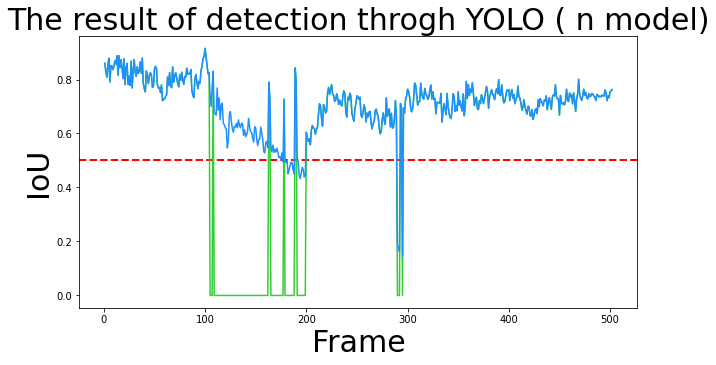

In [149]:
box = {'facecolor':'0.75' ,
       'edgecolor':'k' ,
       'boxstyle': 'round'      
}
plt.figure(figsize=(10,5))
plt.title("The result", size = 30)
plt.ylabel("IoU", size = 30)
plt.xlabel("Frame", size = 30)
plt.axhline(0.5, color='r', linestyle='--', linewidth=2)

plt.plot(x, y_YOLO_s5 ,c = "limegreen")
plt.plot(x, y_Kalman_s5 ,c = "dodgerblue")

# 이미지 저장 유무
# plt.savefig("Plot/YOLO_IOU_n.jpg")


plt.show()

# AP Result

In [104]:
result_YOLO_n = AP(detections_YOLO_n, groundtruths, classes)
result_YOLO_n2 = AP(detections_YOLO_n2, groundtruths, classes)
result_YOLO_n3 = AP(detections_YOLO_n3, groundtruths, classes)
result_YOLO_n4 = AP(detections_YOLO_n4, groundtruths, classes)
result_YOLO_n5 = AP(detections_YOLO_n5, groundtruths, classes)

result_YOLO_s = AP(detections_YOLO_s, groundtruths, classes)
result_YOLO_s2 = AP(detections_YOLO_s2, groundtruths, classes)
result_YOLO_s3 = AP(detections_YOLO_s3, groundtruths, classes)
result_YOLO_s4 = AP(detections_YOLO_s4, groundtruths, classes)
result_YOLO_s5 = AP(detections_YOLO_s5, groundtruths, classes)

result_YOLO_m = AP(detections_YOLO_m, groundtruths, classes)
result_YOLO_m2 = AP(detections_YOLO_m2, groundtruths, classes)
result_YOLO_m3 = AP(detections_YOLO_m3, groundtruths, classes)
result_YOLO_m4 = AP(detections_YOLO_m4, groundtruths, classes)
result_YOLO_m5 = AP(detections_YOLO_m5, groundtruths, classes)

result_YOLO_l = AP(detections_YOLO_l, groundtruths, classes)
result_YOLO_l2 = AP(detections_YOLO_l2, groundtruths, classes)
result_YOLO_l3 = AP(detections_YOLO_l3, groundtruths, classes)
result_YOLO_l4 = AP(detections_YOLO_l4, groundtruths, classes)
result_YOLO_l5 = AP(detections_YOLO_l5, groundtruths, classes)

result_YOLO_xl = AP(detections_YOLO_xl, groundtruths, classes)
result_YOLO_xl2 = AP(detections_YOLO_xl2, groundtruths, classes)
result_YOLO_xl3 = AP(detections_YOLO_xl3, groundtruths, classes)
result_YOLO_xl4 = AP(detections_YOLO_xl4, groundtruths, classes)
result_YOLO_xl5 = AP(detections_YOLO_xl5, groundtruths, classes)

result_Kalman_n = AP(detections_Kalman_n, groundtruths, classes)
result_Kalman_n2 = AP(detections_Kalman_n2, groundtruths, classes)
result_Kalman_n3 = AP(detections_Kalman_n3, groundtruths, classes)
result_Kalman_n4 = AP(detections_Kalman_n4, groundtruths, classes)
result_Kalman_n5 = AP(detections_Kalman_n5, groundtruths, classes)

result_Kalman_s = AP(detections_Kalman_s, groundtruths, classes)
result_Kalman_s2 = AP(detections_Kalman_s2, groundtruths, classes)
result_Kalman_s3 = AP(detections_Kalman_s3, groundtruths, classes)
result_Kalman_s4 = AP(detections_Kalman_s4, groundtruths, classes)
result_Kalman_s5 = AP(detections_Kalman_s5, groundtruths, classes)

result_Kalman_m = AP(detections_Kalman_m, groundtruths, classes)
result_Kalman_m2 = AP(detections_Kalman_m2, groundtruths, classes)
result_Kalman_m3 = AP(detections_Kalman_m3, groundtruths, classes)
result_Kalman_m4 = AP(detections_Kalman_m4, groundtruths, classes)
result_Kalman_m5 = AP(detections_Kalman_m5, groundtruths, classes)

result_Kalman_l = AP(detections_Kalman_l, groundtruths, classes)
result_Kalman_l2 = AP(detections_Kalman_l2, groundtruths, classes)
result_Kalman_l3 = AP(detections_Kalman_l3, groundtruths, classes)
result_Kalman_l4 = AP(detections_Kalman_l4, groundtruths, classes)
result_Kalman_l5 = AP(detections_Kalman_l5, groundtruths, classes)

result_Kalman_xl = AP(detections_Kalman_xl, groundtruths, classes)
result_Kalman_xl2 = AP(detections_Kalman_xl2, groundtruths, classes)
result_Kalman_xl3 = AP(detections_Kalman_xl3, groundtruths, classes)
result_Kalman_xl4 = AP(detections_Kalman_xl4, groundtruths, classes)
result_Kalman_xl5 = AP(detections_Kalman_xl5, groundtruths, classes)


In [105]:
print(mAP(result_YOLO_n))
print(mAP(result_YOLO_n2))
print(mAP(result_YOLO_n3))
print(mAP(result_YOLO_n4))
print(mAP(result_YOLO_n5))
print("==================================")
print(mAP(result_YOLO_s))
print(mAP(result_YOLO_s2))
print(mAP(result_YOLO_s3))
print(mAP(result_YOLO_s4))
print(mAP(result_YOLO_s5))
print("==================================")
print(mAP(result_YOLO_m))
print(mAP(result_YOLO_m2))
print(mAP(result_YOLO_m3))
print(mAP(result_YOLO_m4))
print(mAP(result_YOLO_m5))
print("==================================")
print(mAP(result_YOLO_l))
print(mAP(result_YOLO_l2))
print(mAP(result_YOLO_l3))
print(mAP(result_YOLO_l4))
print(mAP(result_YOLO_l5))
print("==================================")
print(mAP(result_YOLO_xl))
print(mAP(result_YOLO_xl2))
print(mAP(result_YOLO_xl3))
print(mAP(result_YOLO_xl4))
print(mAP(result_YOLO_xl5))

0.682403165517436
0.5504944903520443
0.7111553784860558
0.5597609561752988
0.8145489483927253
0.8784860557768924
0.8167330677290837
0.7290836653386454
0.8266932270916335
0.8147410358565738
0.9362549800796812
0.7131474103585658
0.6733067729083665
0.7449880478087652
0.8745019920318725
0.6175298804780877
0.7768924302788844
0.8207171314741036
0.5809595706499995
0.796812749003984
0.695145065793667
0.5182206296140853
0.7747671347553609
0.7290836653386454
0.5318725099601593


In [106]:
print(mAP(result_Kalman_n))
print(mAP(result_Kalman_n2))
print(mAP(result_Kalman_n3))
print(mAP(result_Kalman_n4))
print(mAP(result_Kalman_n5))
print("==================================")
print(mAP(result_Kalman_s))
print(mAP(result_Kalman_s2))
print(mAP(result_Kalman_s3))
print(mAP(result_Kalman_s4))
print(mAP(result_Kalman_s5))
print("==================================")

print(mAP(result_Kalman_m))
print(mAP(result_Kalman_m2))
print(mAP(result_Kalman_m3))
print(mAP(result_Kalman_m4))
print(mAP(result_Kalman_m5))
print("==================================")

print(mAP(result_Kalman_l))
print(mAP(result_Kalman_l2))
print(mAP(result_Kalman_l3))
print(mAP(result_Kalman_l4))
print(mAP(result_Kalman_l5))
print("==================================")

print(mAP(result_Kalman_xl))
print(mAP(result_Kalman_xl2))
print(mAP(result_Kalman_xl3))
print(mAP(result_Kalman_xl4))
print(mAP(result_Kalman_xl5))

0.7706250017063669
0.6545209726549496
0.8060137561140054
0.6692879090938264
0.9504401975206092
1.0
0.9270976313187953
0.8021587531760646
0.9752597460153797
0.9520636262270736
1.0
0.7199567710210042
0.7528110669575596
0.7567590250046635
0.9248469273376972
0.6566006684306863
0.8049328612809247
0.8465801755963248
0.5682874777437522
0.8211061809031336
0.8092592957470661
0.6224997173840207
0.8801512662310244
0.756606514602864
0.5974069917322286


In [107]:
AP_aver_yn = round((mAP(result_YOLO_n)+mAP(result_YOLO_n2)+mAP(result_YOLO_n3)+\
                    mAP(result_YOLO_n4)+mAP(result_YOLO_n5))/5,4)
AP_aver_kn = round((mAP(result_Kalman_n)+mAP(result_Kalman_n2)+mAP(result_Kalman_n3)+\
                    mAP(result_Kalman_n4)+mAP(result_Kalman_n5))/5,4)
print(AP_aver_yn)
print(AP_aver_kn)
AP_aver_ys = round((mAP(result_YOLO_s)+mAP(result_YOLO_s2)+mAP(result_YOLO_s3)+\
                    mAP(result_YOLO_s4)+mAP(result_YOLO_s5))/5,4)
AP_aver_ks = round((mAP(result_Kalman_s)+mAP(result_Kalman_s2)+mAP(result_Kalman_s3)+\
                    mAP(result_Kalman_s4)+mAP(result_Kalman_s5))/5,4)
print(AP_aver_ys)
print(AP_aver_ks)
AP_aver_ym = round((mAP(result_YOLO_m)+mAP(result_YOLO_m2)+mAP(result_YOLO_m3)+\
                    mAP(result_YOLO_m4)+mAP(result_YOLO_m5))/5,4)
AP_aver_km = round((mAP(result_Kalman_m)+mAP(result_Kalman_m2)+mAP(result_Kalman_m3)+\
              mAP(result_Kalman_m4)+mAP(result_Kalman_m5))/5,4)
print(AP_aver_ym)
print(AP_aver_km)

AP_aver_yl = round((mAP(result_YOLO_l)+mAP(result_YOLO_l2)+mAP(result_YOLO_l3)+\
                    mAP(result_YOLO_l4)+mAP(result_YOLO_l5))/5,4)
AP_aver_kl = round((mAP(result_Kalman_l)+mAP(result_Kalman_l2)+mAP(result_Kalman_l3)+\
              mAP(result_Kalman_l4)+mAP(result_Kalman_l5))/5,4)
print(AP_aver_yl)
print(AP_aver_kl)

AP_aver_yxl = round((mAP(result_YOLO_xl)+mAP(result_YOLO_xl2)+mAP(result_YOLO_xl3)+\
                    mAP(result_YOLO_xl4)+mAP(result_YOLO_xl5))/5,4)
AP_aver_kxl = round((mAP(result_Kalman_xl)+mAP(result_Kalman_xl2)+mAP(result_Kalman_xl3)+\
              mAP(result_Kalman_xl3)+mAP(result_Kalman_xl5))/5,4)
print(AP_aver_yxl)
print(AP_aver_kxl)


0.6637
0.7702
0.8131
0.9313
0.7884
0.8309
0.7186
0.7395
0.6498
0.7579


In [108]:

df_YOLO = pd.DataFrame([[AP_aver_yn, 99.22],
                       [AP_aver_ys, 92.47],
                       [AP_aver_ym, 68.73],
                       [AP_aver_yl, 53.65],
                       [AP_aver_yxl, 45.01]]
                      ,columns = ['AP', 'FPS']
                      ,index = ['n','s','m','l','xl'])


df_Kalman = pd.DataFrame([[AP_aver_kn, 99.05],
                       [AP_aver_ks, 91.78],
                       [AP_aver_km, 68.20],
                       [AP_aver_kl, 53.16],
                       [AP_aver_kxl, 44.18]]
                        ,columns = ['AP', 'FPS']
                      ,index = ['n','s','m','l','xl'])

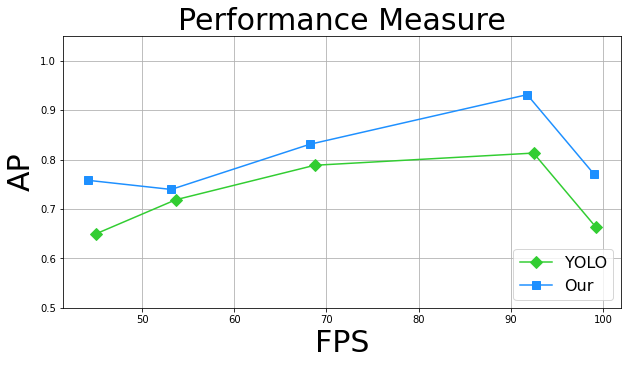

In [109]:
plt.figure(figsize=(10,5))
plt.title("Performance Measure", size = 30)
plt.ylabel("AP", size = 30)
plt.xlabel("FPS", size = 30)
plt.ylim(0.5,1.05)
plt.plot(df_YOLO[['FPS']],df_YOLO[['AP']] , c= 'limegreen', marker = 'D',markersize=8, label= 'YOLO')
plt.plot(df_Kalman[['FPS']],df_Kalman[['AP']], c = "dodgerblue", marker = 's' ,markersize=8,  label= 'Our')
plt.grid(True)
plt.legend(loc = 'lower right', fontsize=16)

plt.savefig("Plot/Performance_Measure_0.35.jpg")
plt.show()


In [5]:

df_YOLO_35 = pd.DataFrame([[0.7212, 99.22],
                       [0.8131, 92.47],
                       [0.7888, 68.73],
                       [0.7186, 53.65],
                       [0.6553, 45.01]]
                      ,columns = ['AP', 'FPS']
                      ,index = ['n','s','m','l','xl'])


df_Kalman_35 = pd.DataFrame([[0.8284, 99.05],
                       [0.9298, 91.78],
                       [0.8451, 68.20],
                       [0.7729, 53.16],
                       [0.7791, 44.18]]
                        ,columns = ['AP', 'FPS']
                      ,index = ['n','s','m','l','xl'])



df_YOLO_25 = pd.DataFrame([[0.7502, 97.88],
                       [0.8417, 92.27],
                       [0.8255, 69.94],
                       [0.7355, 52.76],
                       [0.6778, 44.56]]
                      ,columns = ['AP', 'FPS']
                      ,index = ['n','s','m','l','xl'])


df_Kalman_25 = pd.DataFrame([[0.9143, 96.37],
                       [0.9816, 89.47],
                       [0.9132, 67.79],
                       [0.8099, 52.70],
                       [0.7855, 43.85]]
                        ,columns = ['AP', 'FPS']
                      ,index = ['n','s','m','l','xl'])

df_YOLO_5 = pd.DataFrame([[0.7194, 98.15],
                       [0.7769, 90.79],
                       [0.7386, 69.07],
                       [0.6765, 53.08],
                       [0.6219, 44.50]]
                      ,columns = ['AP', 'FPS']
                      ,index = ['n','s','m','l','xl'])


df_Kalman_5 = pd.DataFrame([[0.8283, 96.58],
                       [0.9298, 89.62],
                       [0.8451, 67.39],
                       [0.7729, 52.70],
                       [0.7791, 43.84]]
                        ,columns = ['AP', 'FPS']
                      ,index = ['n','s','m','l','xl'])


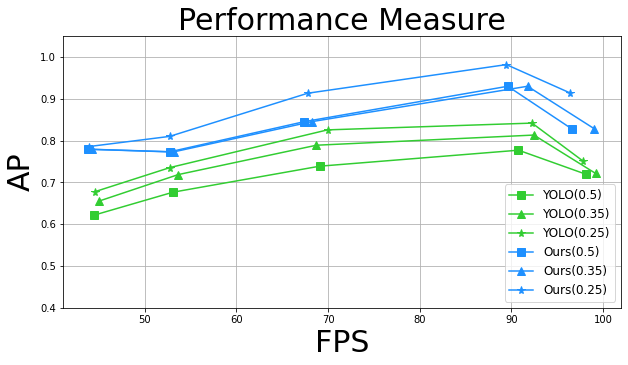

In [6]:
plt.figure(figsize=(10,5))
plt.title("Performance Measure", size = 30)
plt.ylabel("AP", size = 30)
plt.xlabel("FPS", size = 30)
plt.ylim(0.4,1.05)
plt.plot(df_YOLO_5[['FPS']],df_YOLO_5[['AP']] , c= 'limegreen', marker = 's',markersize=8, label= 'YOLO(0.5)')
plt.plot(df_YOLO_35[['FPS']],df_YOLO_35[['AP']] , c= 'limegreen', marker = '^',markersize=8, label= 'YOLO(0.35)')
plt.plot(df_YOLO_25[['FPS']],df_YOLO_25[['AP']] , c= 'limegreen', marker = '*',markersize=8, label= 'YOLO(0.25)')

plt.plot(df_Kalman_5[['FPS']],df_Kalman_5[['AP']], c = "dodgerblue", marker = 's' ,markersize=8,  label= 'Ours(0.5)')
plt.plot(df_Kalman_35[['FPS']],df_Kalman_35[['AP']], c = "dodgerblue", marker = '^' ,markersize=8,  label= 'Ours(0.35)')
plt.plot(df_Kalman_25[['FPS']],df_Kalman_25[['AP']], c = "dodgerblue", marker = '*' ,markersize=8,  label= 'Ours(0.25)')

plt.grid(True)
plt.legend(loc = 'lower right', fontsize=12)

plt.savefig("Plot/Performance_Measure_all.jpg")
plt.show()


In [62]:
df_YOLOv5_n = pd.DataFrame([[0.7502, 97.88],
                       [0.7212, 99.22],
                       [0.7194, 98.15]]
                        ,columns = ['AP', 'FPS']
                      ,index = ['0.25','0.35','0.5'])

df_Ours_n = pd.DataFrame([[0.9143, 96.37],
                       [0.8838, 99.06],
                       [0.8283, 96.58]]
                        ,columns = ['AP', 'FPS']
                      ,index = ['0.25','0.35','0.5'])

df_YOLOv5_s = pd.DataFrame([[0.8417, 92.27],
                       [0.8131, 92.47],
                       [0.7769, 90.79]]
                        ,columns = ['AP', 'FPS']
                      ,index = ['0.25','0.35','0.5'])

df_Ours_s = pd.DataFrame([[0.9816, 89.47],
                       [0.9966, 91.78],
                       [0.9298, 89.62]]
                        ,columns = ['AP', 'FPS']
                      ,index = ['0.25','0.35','0.5'])

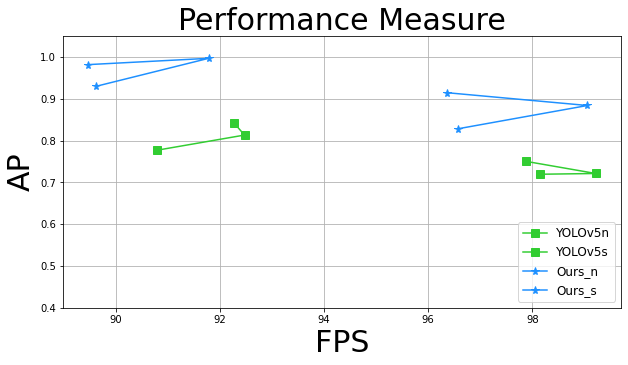

In [64]:
plt.figure(figsize=(10,5))
plt.title("Performance Measure", size = 30)
plt.ylabel("AP", size = 30)
plt.xlabel("FPS", size = 30)
plt.ylim(0.4,1.05)
plt.plot(df_YOLOv5_n[['FPS']],df_YOLOv5_n[['AP']] , c= 'limegreen', marker = 's',markersize=8, label= 'YOLOv5n')
plt.plot(df_YOLOv5_s[['FPS']],df_YOLOv5_s[['AP']] , c= 'limegreen', marker = 's',markersize=8, label= 'YOLOv5s')

plt.plot(df_Ours_n[['FPS']],df_Ours_n[['AP']], c = "dodgerblue", marker = '*' ,markersize=8,  label= 'Ours_n')
plt.plot(df_Ours_s[['FPS']],df_Ours_s[['AP']], c = "dodgerblue", marker = '*' ,markersize=8,  label= 'Ours_s')

plt.grid(True)
plt.legend(loc = 'lower right', fontsize=12)

plt.savefig("Plot/test.jpg")
plt.show()


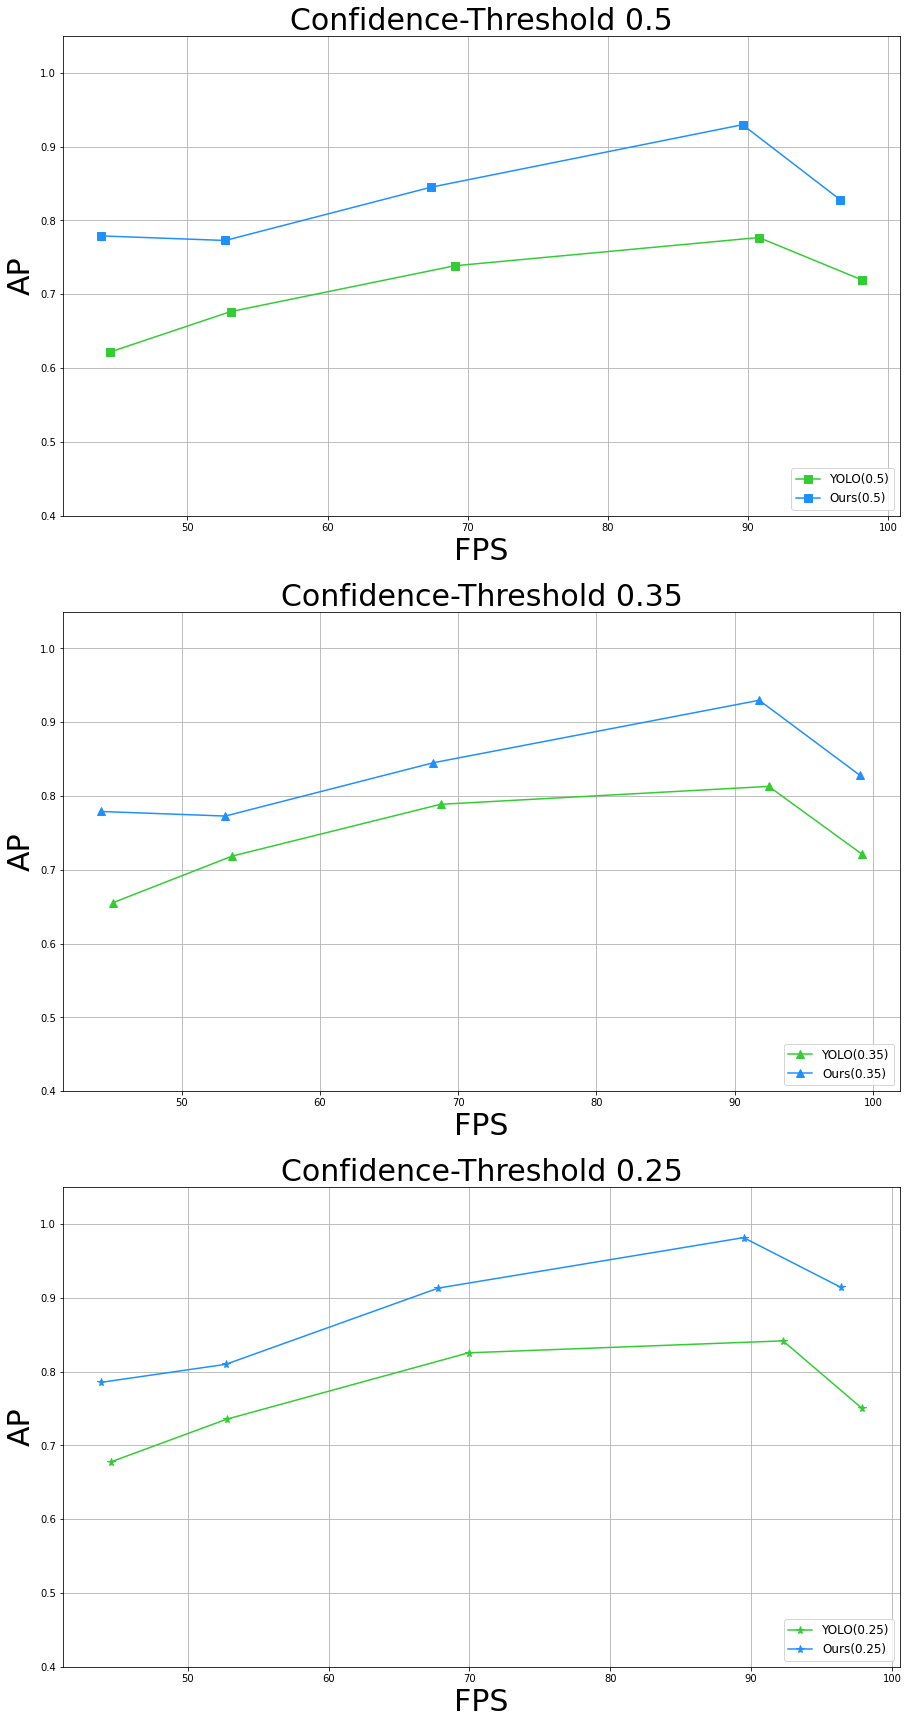

In [35]:
plt.figure(figsize=(15,30))

plt.subplot(3,1,1)
plt.plot(df_YOLO_5[['FPS']],df_YOLO_5[['AP']] , c= 'limegreen', marker = 's',markersize=8, label= 'YOLO(0.5)')
plt.plot(df_Kalman_5[['FPS']],df_Kalman_5[['AP']], c = "dodgerblue", marker = 's' ,markersize=8,  label= 'Ours(0.5)')
plt.title("Confidence-Threshold 0.5", size = 30)
plt.ylabel("AP", size = 30)
plt.xlabel("FPS", size = 30)
plt.ylim(0.4,1.05)
plt.grid(True)
plt.legend(loc = 'lower right', fontsize=12)

plt.subplot(3,1,2)
plt.plot(df_YOLO_35[['FPS']],df_YOLO_35[['AP']] , c= 'limegreen', marker = '^',markersize=8, label= 'YOLO(0.35)')
plt.plot(df_Kalman_35[['FPS']],df_Kalman_35[['AP']], c = "dodgerblue", marker = '^' ,markersize=8,  label= 'Ours(0.35)')
plt.title("Confidence-Threshold 0.35", size = 30)
plt.ylabel("AP", size = 30)
plt.xlabel("FPS", size = 30)
plt.ylim(0.4,1.05)
plt.grid(True)
plt.legend(loc = 'lower right', fontsize=12)

plt.subplot(3,1,3)
plt.plot(df_YOLO_25[['FPS']],df_YOLO_25[['AP']] , c= 'limegreen', marker = '*',markersize=8, label= 'YOLO(0.25)')
plt.plot(df_Kalman_25[['FPS']],df_Kalman_25[['AP']], c = "dodgerblue", marker = '*' ,markersize=8,  label= 'Ours(0.25)')
plt.title("Confidence-Threshold 0.25", size = 30)
plt.ylabel("AP", size = 30)
plt.xlabel("FPS", size = 30)
plt.ylim(0.4,1.05)
plt.grid(True)
plt.legend(loc = 'lower right', fontsize=12)

plt.savefig("Plot/Performance_Measure_ALL.jpg")
plt.show()
